In [1]:
%matplotlib inline
import seaborn as sns
import matplotlib.pyplot as plt

import pandas as pd
import numpy as np
import itertools

import tensorflow as tf

from keras.models import *
from keras.layers import *
from keras.optimizers import *

from sklearn.metrics import confusion_matrix, accuracy_score, f1_score
from sklearn.model_selection import train_test_split
from sklearn.utils import class_weight

/opt/conda/lib/python3.7/site-packages/tensorflow/python/framework/dtypes.py:526: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint8 = np.dtype([("qint8", np.int8, 1)])
/opt/conda/lib/python3.7/site-packages/tensorflow/python/framework/dtypes.py:527: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_quint8 = np.dtype([("quint8", np.uint8, 1)])
/opt/conda/lib/python3.7/site-packages/tensorflow/python/framework/dtypes.py:528: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint16 = np.dtype([("qint16", np.int16, 1)])
/opt/conda/lib/python3.7/site-packages/tensorflow/python/framework/dtypes.py:529: FutureWarning: Passing (type, 1) or 

In [2]:
df = pd.read_csv('../raw_data/training_data.csv')
df.head()

,cell_code,cell_id,plate,replicate,well,field,actin.s.area,actin.s.perimeter,actin.s.radius.mean,actin.s.radius.sd,...,DNA.h.ent.s3,DNA.h.dva.s3,DNA.h.den.s3,DNA.h.f12.s3,DNA.h.f13.s3,dist.10.nn,dist.20.nn,dist.30.nn,nuclear.displacement,target
0,OaJHcDs2kh,1,P1,1,C10,1,579,90,13.942759,4.352958,...,0.0,0.0,0.0,0.0,0.0,128.889522,178.595764,207.187370,5.938882,adrenoceptor
1,nwLFF4l070,2,P1,1,C10,1,1132,136,20.179007,4.583255,...,0.0,0.0,0.0,0.0,0.0,79.885304,123.697473,190.598760,0.478024,adrenoceptor
2,JU4SIplWZ7,3,P1,1,C10,1,736,99,15.209404,2.408709,...,0.0,0.0,0.0,0.0,0.0,64.370636,88.931673,127.452918,3.928325,adrenoceptor
3,pqkTwaHa2L,4,P1,1,C10,1,611,92,14.398528,3.662234,...,0.0,0.0,0.0,0.0,0.0,87.536494,121.879169,160.752674,3.336081,adrenoceptor
4,pB2BlQoW94,5,P1,1,C10,1,585,93,14.030675,3.408844,...,0.0,0.0,0.0,0.0,0.0,105.866735,142.023858,182.990012,2.343776,adrenoceptor


In [3]:
def load_data(filename, features, scaling_method):
    df = pd.read_csv(filename)
    df = df.sample(frac=1).reset_index(drop=True)
    X = np.asarray(df[features], dtype='float')
    
    if scaling_method == 'z-score':
        mu = np.nanmean(X, axis=0)
        var = np.nanstd(X, axis=0)
        X = (X - mu) / var

    # Get targets to one-hot encoding
    f = pd.factorize(df['target'])
    y = np.zeros((f[0].shape[0], len(set(f[0]))))
    y[np.arange(f[0].shape[0]), f[0].T] = 1
    targets = f[1]
    
    return X, y, targets

def load_validation_data(filename, features, scaling_method):
    df = pd.read_csv(filename)
    df = df.sample(frac=1).reset_index(drop=True)
    X = np.asarray(df[features], dtype='float')
    
    if scaling_method == 'z-score':
        mu = np.nanmean(X, axis=0)
        var = np.nanstd(X, axis=0)
        X = (X - mu) / var
        
    X_codes = df['cell_code']
    
    return X, X_codes

In [4]:
def train_NN_model(X, y, param, targets):   
    
    # Split training and test sets
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=params['percent_to_test'])

    # Hyper-parameters
    input_units = X_train.shape[1]
    output_units = len(targets)
    
    # Construct NN architecture
    model = Sequential()
    model.add(Dense(80, input_dim=input_units, kernel_initializer='glorot_normal'))
    model.add(normalization.BatchNormalization(axis=1))
    model.add(Activation('relu'))
    model.add(Dropout(0.1))
    model.add(Dense(40, kernel_initializer='glorot_normal'))
    model.add(normalization.BatchNormalization(axis=1))
    model.add(Activation('relu'))
    model.add(Dropout(0.1))
    model.add(Dense(output_units, kernel_initializer='glorot_normal'))
    model.add(Activation('softmax'))

    # Optimization method
    model.compile(loss='categorical_crossentropy', optimizer=Adadelta(), metrics=['accuracy'])

    # Fit training data
    hist = model.fit(X_train, y_train, epochs=params['num_epochs'],
                     batch_size=params['batch_size'], validation_split=params['percent_to_valid'])

    # Evaluate model
    score = model.evaluate(X_test, y_test, batch_size=params['batch_size'])
    print('\nTest %s: %.2f' % (model.metrics_names[0], score[0]))
    print('Test %s: %.2f%%' % (model.metrics_names[1], score[1]*100))

    # Make predictions
    y_pred = model.predict(X_test, batch_size=params['batch_size'])
    y_pred = [targets[i] for i in np.argmax(y_pred, axis=1)]
    y_true = [targets[i] for i in np.argmax(y_test, axis=1)]

    # Print prediction performance on F1-score
    f1 = f1_score(y_true, y_pred, average='macro')  
    print('F1-Score: %.2f' % f1)
    
    unpredicted_classes = list(set(y_true) - set(y_pred))
    if len(unpredicted_classes):
        print('THESE CLASSES ARE NOT PREDICTED - SCORING WILL FAIL!')
        print(unpredicted_classes)

    # Plot confusion matrix
    cm = confusion_matrix(y_true, y_pred, targets)
    plt.figure(figsize=(10, 10))
    plt.imshow(cm, interpolation='nearest', cmap=plt.cm.viridis)
    tick_marks = np.arange(len(targets))
    plt.xticks(tick_marks, targets, rotation=45, ha='right')
    plt.yticks(tick_marks, targets)
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, cm[i, j], horizontalalignment='center', color='black')

    plt.ylabel('True label')
    plt.xlabel('Predicted label')

    return model

In [5]:
def save_predictions(validation_filename, features, output_prefix, targets, scaling_method):
    # Load validation data
    X_valid, valid_cell_codes = load_validation_data(validation_filename, features, scaling_method)

    # Predict target probabilities
    y_valid_prob = model.predict(X_valid, batch_size=params['batch_size'])
    df_valid_prob = pd.DataFrame(columns=target_names, data=y_valid_prob)
    df_valid_prob.insert(0, 'cell_code', valid_cell_codes)

    # Predictions on maximum probabilities
    df_valid_pred = pd.DataFrame(columns = ['cell_code', 'prediction'])
    df_valid_pred['cell_code'] = df_valid_prob['cell_code']
    df_valid_pred['prediction'] = [targets[i] for i in np.argmax(y_valid_prob, axis=1)]

    # Save predictions
    df_valid_prob.to_csv('%s_probabilities.csv' % output_prefix, index=False)
    df_valid_pred.to_csv('%s.csv' % output_prefix, index=False)

In [6]:
# Input options

filename = '../raw_data/training_data.csv'

features = ['actin.s.area', 'actin.s.perimeter', 'actin.s.radius.mean',
       'actin.s.radius.sd', 'actin.s.radius.min', 'actin.s.radius.max',
       'actin.b.mean', 'actin.b.sd', 'actin.b.mad', 'actin.b.q005',
       'actin.b.q01', 'actin.b.q05', 'actin.m.cx', 'actin.m.cy',
       'actin.m.majoraxis', 'actin.m.eccentricity', 'actin.m.theta',
       'actin.h.asm.s1', 'actin.h.con.s1', 'actin.h.cor.s1',
       'actin.h.var.s1', 'actin.h.idm.s1', 'actin.h.sav.s1',
       'actin.h.sva.s1', 'actin.h.sen.s1', 'actin.h.ent.s1',
       'actin.h.dva.s1', 'actin.h.den.s1', 'actin.h.f12.s1',
       'actin.h.f13.s1', 'actin.h.asm.s2', 'actin.h.con.s2',
       'actin.h.cor.s2', 'actin.h.var.s2', 'actin.h.idm.s2',
       'actin.h.sav.s2', 'actin.h.sva.s2', 'actin.h.sen.s2',
       'actin.h.ent.s2', 'actin.h.dva.s2', 'actin.h.den.s2',
       'actin.h.f12.s2', 'actin.h.f13.s2', 'actin.h.asm.s3',
       'actin.h.con.s3', 'actin.h.cor.s3', 'actin.h.var.s3',
       'actin.h.idm.s3', 'actin.h.sav.s3', 'actin.h.sva.s3',
       'actin.h.sen.s3', 'actin.h.ent.s3', 'actin.h.dva.s3',
       'actin.h.den.s3', 'actin.h.f12.s3', 'actin.h.f13.s3', 'DNA.s.area',
       'DNA.s.perimeter', 'DNA.s.radius.mean', 'DNA.s.radius.sd',
       'DNA.s.radius.min', 'DNA.s.radius.max', 'DNA.b.mean', 'DNA.b.sd',
       'DNA.b.mad', 'DNA.b.q005', 'DNA.b.q01', 'DNA.b.q05', 'DNA.m.cx',
       'DNA.m.cy', 'DNA.m.majoraxis', 'DNA.m.eccentricity', 'DNA.m.theta',
       'DNA.h.asm.s1', 'DNA.h.con.s1', 'DNA.h.cor.s1', 'DNA.h.var.s1',
       'DNA.h.idm.s1', 'DNA.h.sav.s1', 'DNA.h.sva.s1', 'DNA.h.sen.s1',
       'DNA.h.ent.s1', 'DNA.h.dva.s1', 'DNA.h.den.s1', 'DNA.h.f12.s1',
       'DNA.h.f13.s1', 'DNA.h.asm.s2', 'DNA.h.con.s2', 'DNA.h.cor.s2',
       'DNA.h.var.s2', 'DNA.h.idm.s2', 'DNA.h.sav.s2', 'DNA.h.sva.s2',
       'DNA.h.sen.s2', 'DNA.h.ent.s2', 'DNA.h.dva.s2', 'DNA.h.den.s2',
       'DNA.h.f12.s2', 'DNA.h.f13.s2', 'DNA.h.asm.s3', 'DNA.h.con.s3',
       'DNA.h.cor.s3', 'DNA.h.var.s3', 'DNA.h.idm.s3', 'DNA.h.sav.s3',
       'DNA.h.sva.s3', 'DNA.h.sen.s3', 'DNA.h.ent.s3', 'DNA.h.dva.s3',
       'DNA.h.den.s3', 'DNA.h.f12.s3', 'DNA.h.f13.s3', 'dist.10.nn',
       'dist.20.nn', 'dist.30.nn', 'nuclear.displacement']

params = {'percent_to_valid': 0.2,
          'percent_to_test': 0.1,
          'num_epochs': 200,
          'batch_size': 256}

Instructions for updating:
Colocations handled automatically by placer.
Instructions for updating:
Please use `rate` instead of `keep_prob`. Rate should be set to `rate = 1 - keep_prob`.
Instructions for updating:
Use tf.cast instead.
Train on 36912 samples, validate on 9228 samples
Epoch 1/200
36912/36912 [==============================] - 3s 71us/step - loss: 2.5496 - acc: 0.1602 - val_loss: 2.3260 - val_acc: 0.2220
Epoch 2/200
36912/36912 [==============================] - 1s 28us/step - loss: 2.3044 - acc: 0.2180 - val_loss: 2.2307 - val_acc: 0.2479
Epoch 3/200
36912/36912 [==============================] - 2s 64us/step - loss: 2.2514 - acc: 0.2314 - val_loss: 2.1915 - val_acc: 0.2543
Epoch 4/200
36912/36912 [==============================] - 1s 24us/step - loss: 2.2177 - acc: 0.2438 - val_loss: 2.1691 - val_acc: 0.2628
Epoch 5/200
36912/36912 [==============================] - 2s 60us/step - loss: 2.1950 - acc: 0.2491 - val_loss: 2.1566 - val_acc: 0.2654
Epoch 6/200
36912/36912 [=

36912/36912 [==============================] - 1s 21us/step - loss: 2.0476 - acc: 0.2987 - val_loss: 2.0521 - val_acc: 0.3030
Epoch 54/200
36912/36912 [==============================] - 1s 20us/step - loss: 2.0457 - acc: 0.2994 - val_loss: 2.0503 - val_acc: 0.3053
Epoch 55/200
36912/36912 [==============================] - 1s 20us/step - loss: 2.0398 - acc: 0.3018 - val_loss: 2.0484 - val_acc: 0.3015
Epoch 56/200
36912/36912 [==============================] - 1s 21us/step - loss: 2.0448 - acc: 0.3026 - val_loss: 2.0512 - val_acc: 0.3027
Epoch 57/200
36912/36912 [==============================] - 1s 22us/step - loss: 2.0397 - acc: 0.3036 - val_loss: 2.0480 - val_acc: 0.3049
Epoch 58/200
36912/36912 [==============================] - 1s 20us/step - loss: 2.0392 - acc: 0.3039 - val_loss: 2.0504 - val_acc: 0.3039
Epoch 59/200
36912/36912 [==============================] - 1s 19us/step - loss: 2.0358 - acc: 0.3039 - val_loss: 2.0476 - val_acc: 0.3005
Epoch 60/200
36912/36912 [==============

Epoch 112/200
36912/36912 [==============================] - 1s 21us/step - loss: 2.0065 - acc: 0.3126 - val_loss: 2.0326 - val_acc: 0.3086
Epoch 113/200
36912/36912 [==============================] - 1s 21us/step - loss: 2.0040 - acc: 0.3131 - val_loss: 2.0366 - val_acc: 0.3055
Epoch 114/200
36912/36912 [==============================] - 1s 21us/step - loss: 2.0045 - acc: 0.3139 - val_loss: 2.0332 - val_acc: 0.3066
Epoch 115/200
36912/36912 [==============================] - 1s 18us/step - loss: 2.0026 - acc: 0.3153 - val_loss: 2.0393 - val_acc: 0.3048
Epoch 116/200
36912/36912 [==============================] - 1s 19us/step - loss: 2.0037 - acc: 0.3157 - val_loss: 2.0355 - val_acc: 0.3092
Epoch 117/200
36912/36912 [==============================] - 1s 20us/step - loss: 2.0051 - acc: 0.3164 - val_loss: 2.0389 - val_acc: 0.3047
Epoch 118/200
36912/36912 [==============================] - 1s 18us/step - loss: 2.0028 - acc: 0.3134 - val_loss: 2.0375 - val_acc: 0.3062
Epoch 119/200
36912/

36912/36912 [==============================] - 1s 20us/step - loss: 1.9854 - acc: 0.3198 - val_loss: 2.0348 - val_acc: 0.3110
Epoch 171/200
36912/36912 [==============================] - 1s 21us/step - loss: 1.9909 - acc: 0.3222 - val_loss: 2.0319 - val_acc: 0.3120
Epoch 172/200
36912/36912 [==============================] - 1s 22us/step - loss: 1.9863 - acc: 0.3218 - val_loss: 2.0376 - val_acc: 0.3127
Epoch 173/200
36912/36912 [==============================] - 1s 21us/step - loss: 1.9868 - acc: 0.3213 - val_loss: 2.0349 - val_acc: 0.3108
Epoch 174/200
36912/36912 [==============================] - 1s 21us/step - loss: 1.9863 - acc: 0.3210 - val_loss: 2.0358 - val_acc: 0.3103
Epoch 175/200
36912/36912 [==============================] - 1s 20us/step - loss: 1.9892 - acc: 0.3201 - val_loss: 2.0323 - val_acc: 0.3098
Epoch 176/200
36912/36912 [==============================] - 1s 20us/step - loss: 1.9870 - acc: 0.3201 - val_loss: 2.0314 - val_acc: 0.3119
Epoch 177/200
36912/36912 [=======

/opt/conda/lib/python3.7/site-packages/sklearn/metrics/classification.py:1437: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)


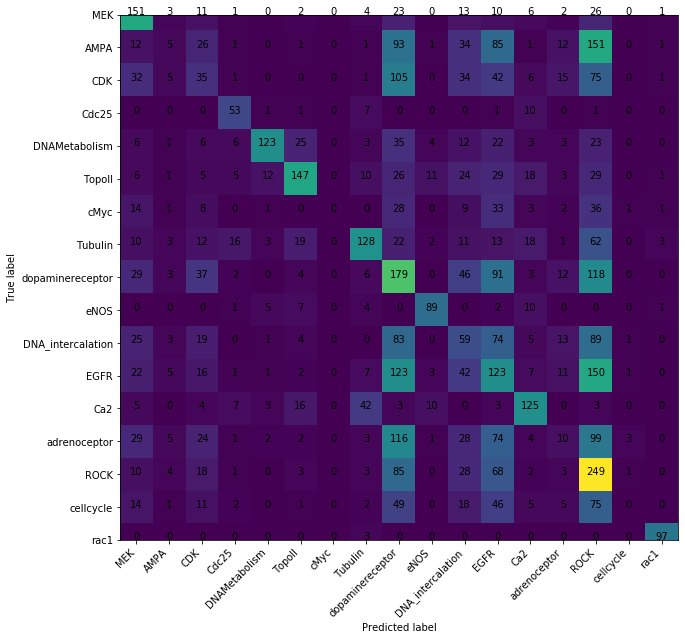

In [7]:
X_train, y_train, target_names = load_data(filename, features, 'z-score')
model = train_NN_model(X_train, y_train, params, target_names)

In [8]:
validation_filename = '../raw_data/validation_data.csv'
output_prefix = 'predictions_NN'
save_predictions(validation_filename, features, output_prefix, target_names, 'z-score')